In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [20, 5]

import tensorflow as tf
tf.keras.backend.clear_session()

In [2]:
dataset = pd.read_csv('measurements.csv', sep=';', decimal=',')
dataset = dataset.dropna()
dataset.drop(dataset.columns[[0, 1, 2]], axis = 1, inplace = True) 

max_tube_diameter = np.min(dataset[['AP cricoïde', 'AP fin de trachée', 'T fin de trachée']], axis=1)
dataset= dataset.iloc[:, :3]

cuffless_OD = np.array([2.9, 3.6, 4.2, 4.9, 5.5, 6.2, 6.8, 7.5, 8.2, 8.8, 9.6])
cuffed_OD = np.array([4.2, 5.5, 6.8, 7.5, 8.2, 8.8, 9.6, 10.2, 10.9, 11.5, 12.1, 12.8, 13.5])

# CUFFLESS
ds_cuffless = dataset.copy()
od = np.array([cuffless_OD[np.abs(cuffless_OD - mtd).argmin()] for mtd in max_tube_diameter])
ds_cuffless['OD class ref'] = [j if i>0 else j-1 
                                for i, j in zip(np.sign(max_tube_diameter - od),
                                                [np.where(cuffless_OD == c)[0].item() for c in od])]
ds_cuffless = ds_cuffless[ds_cuffless['OD class ref'] != -1]

# CUFFED
ds_cuffed = dataset.copy()
od = np.array([cuffed_OD[np.abs(cuffed_OD - mtd).argmin()] for mtd in max_tube_diameter])
ds_cuffed['OD class ref'] = [j if i>0 else j-1 
                                for i, j in zip(np.sign(max_tube_diameter - od),
                                                [np.where(cuffed_OD == c)[0].item() for c in od])]
ds_cuffed = ds_cuffed[ds_cuffed['OD class ref'] != -1]

In [3]:
# CUFFLESS
train_dataset_cuffless = ds_cuffless.sample(frac=0.8, random_state=42)
test_dataset_cuffless = ds_cuffless.drop(train_dataset_cuffless.index)

# CUFFED
train_dataset_cuffed = ds_cuffed.sample(frac=0.8, random_state=42)
test_dataset_cuffed = ds_cuffed.drop(train_dataset_cuffed.index)

In [4]:
# CUFFLESS
train_features_cuffless = train_dataset_cuffless.copy()
train_target_cuffless = tf.one_hot(train_features_cuffless.pop('OD class ref'), 10)
test_features_cuffless = test_dataset_cuffless.copy()
test_target_cuffless = tf.one_hot(test_features_cuffless.pop('OD class ref'), 10)

# CUFFED
train_features_cuffed = train_dataset_cuffed.copy()
train_target_cuffed = tf.one_hot(train_features_cuffed.pop('OD class ref'), 10)
test_features_cuffed = test_dataset_cuffed.copy()
test_target_cuffed = tf.one_hot(test_features_cuffed.pop('OD class ref'), 10)

In [5]:
# CUFFLESS
normalizer_cuffless = tf.keras.layers.experimental.preprocessing.Normalization()
normalizer_cuffless.adapt(np.array(train_features_cuffless))

model_cuffless = tf.keras.Sequential([
    normalizer_cuffless,
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

model_cuffless.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=[tf.keras.metrics.CategoricalAccuracy()])

history_cuffless = model_cuffless.fit(x=train_features_cuffless, y=train_target_cuffless,
                                      validation_data=(test_features_cuffless, test_target_cuffless),
                                      epochs=300)

# CUFFED
normalizer_cuffed = tf.keras.layers.experimental.preprocessing.Normalization()
normalizer_cuffed.adapt(np.array(train_features_cuffed))

model_cuffed = tf.keras.Sequential([
    normalizer_cuffed,
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

model_cuffed.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=[tf.keras.metrics.CategoricalAccuracy()])

history_cuffed = model_cuffed.fit(x=train_features_cuffed, y=train_target_cuffed,
                                  validation_data=(test_features_cuffed, test_target_cuffed),
                                  epochs=300)

Epoch 1/300
5/5 [==============================] - 0s 21ms/step - loss: 0.0796 - categorical_accuracy: 0.1830 - val_loss: 0.0732 - val_categorical_accuracy: 0.1316
Epoch 2/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0790 - categorical_accuracy: 0.2353 - val_loss: 0.0730 - val_categorical_accuracy: 0.1579
Epoch 3/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0785 - categorical_accuracy: 0.2418 - val_loss: 0.0728 - val_categorical_accuracy: 0.1053
Epoch 4/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0780 - categorical_accuracy: 0.2353 - val_loss: 0.0728 - val_categorical_accuracy: 0.1053
Epoch 5/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0776 - categorical_accuracy: 0.2288 - val_loss: 0.0727 - val_categorical_accuracy: 0.1053
Epoch 6/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0773 - categorical_accuracy: 0.2288 - val_loss: 0.0727 - val_categorical_accuracy: 0.1053
Epoch 7/300
5/5 [====

5/5 [==============================] - 0s 3ms/step - loss: 0.0716 - categorical_accuracy: 0.3203 - val_loss: 0.0725 - val_categorical_accuracy: 0.1579
Epoch 52/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0715 - categorical_accuracy: 0.3203 - val_loss: 0.0726 - val_categorical_accuracy: 0.1579
Epoch 53/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0715 - categorical_accuracy: 0.3137 - val_loss: 0.0726 - val_categorical_accuracy: 0.1579
Epoch 54/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0714 - categorical_accuracy: 0.3203 - val_loss: 0.0726 - val_categorical_accuracy: 0.1579
Epoch 55/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0713 - categorical_accuracy: 0.3268 - val_loss: 0.0726 - val_categorical_accuracy: 0.1579
Epoch 56/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0713 - categorical_accuracy: 0.3268 - val_loss: 0.0726 - val_categorical_accuracy: 0.1579
Epoch 57/300
5/5 [===========

5/5 [==============================] - 0s 3ms/step - loss: 0.0694 - categorical_accuracy: 0.3529 - val_loss: 0.0726 - val_categorical_accuracy: 0.1579
Epoch 102/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0694 - categorical_accuracy: 0.3529 - val_loss: 0.0727 - val_categorical_accuracy: 0.1579
Epoch 103/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0693 - categorical_accuracy: 0.3529 - val_loss: 0.0726 - val_categorical_accuracy: 0.1579
Epoch 104/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0693 - categorical_accuracy: 0.3529 - val_loss: 0.0726 - val_categorical_accuracy: 0.1579
Epoch 105/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0693 - categorical_accuracy: 0.3529 - val_loss: 0.0726 - val_categorical_accuracy: 0.1579
Epoch 106/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0692 - categorical_accuracy: 0.3529 - val_loss: 0.0725 - val_categorical_accuracy: 0.1579
Epoch 107/300
5/5 [=====

Epoch 151/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0680 - categorical_accuracy: 0.3660 - val_loss: 0.0720 - val_categorical_accuracy: 0.1842
Epoch 152/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0680 - categorical_accuracy: 0.3660 - val_loss: 0.0720 - val_categorical_accuracy: 0.1842
Epoch 153/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0680 - categorical_accuracy: 0.3660 - val_loss: 0.0720 - val_categorical_accuracy: 0.1842
Epoch 154/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0679 - categorical_accuracy: 0.3660 - val_loss: 0.0719 - val_categorical_accuracy: 0.1842
Epoch 155/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0679 - categorical_accuracy: 0.3660 - val_loss: 0.0719 - val_categorical_accuracy: 0.1842
Epoch 156/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0679 - categorical_accuracy: 0.3595 - val_loss: 0.0719 - val_categorical_accuracy: 0.1842
Epoch 157/

Epoch 201/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0670 - categorical_accuracy: 0.3791 - val_loss: 0.0716 - val_categorical_accuracy: 0.1842
Epoch 202/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0670 - categorical_accuracy: 0.3791 - val_loss: 0.0716 - val_categorical_accuracy: 0.1842
Epoch 203/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0669 - categorical_accuracy: 0.3725 - val_loss: 0.0716 - val_categorical_accuracy: 0.1842
Epoch 204/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0669 - categorical_accuracy: 0.3791 - val_loss: 0.0716 - val_categorical_accuracy: 0.1842
Epoch 205/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0669 - categorical_accuracy: 0.3725 - val_loss: 0.0716 - val_categorical_accuracy: 0.1842
Epoch 206/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0669 - categorical_accuracy: 0.3725 - val_loss: 0.0717 - val_categorical_accuracy: 0.1842
Epoch 207/

Epoch 251/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0662 - categorical_accuracy: 0.3725 - val_loss: 0.0714 - val_categorical_accuracy: 0.1842
Epoch 252/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0661 - categorical_accuracy: 0.3725 - val_loss: 0.0714 - val_categorical_accuracy: 0.1842
Epoch 253/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0661 - categorical_accuracy: 0.3791 - val_loss: 0.0713 - val_categorical_accuracy: 0.1842
Epoch 254/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0661 - categorical_accuracy: 0.3725 - val_loss: 0.0713 - val_categorical_accuracy: 0.1842
Epoch 255/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0661 - categorical_accuracy: 0.3791 - val_loss: 0.0713 - val_categorical_accuracy: 0.1842
Epoch 256/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0661 - categorical_accuracy: 0.3791 - val_loss: 0.0713 - val_categorical_accuracy: 0.1842
Epoch 257/

Epoch 1/300
5/5 [==============================] - 0s 17ms/step - loss: 0.0894 - categorical_accuracy: 0.0816 - val_loss: 0.0862 - val_categorical_accuracy: 0.0811
Epoch 2/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0886 - categorical_accuracy: 0.1224 - val_loss: 0.0856 - val_categorical_accuracy: 0.0811
Epoch 3/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0878 - categorical_accuracy: 0.1497 - val_loss: 0.0850 - val_categorical_accuracy: 0.0811
Epoch 4/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0871 - categorical_accuracy: 0.1565 - val_loss: 0.0844 - val_categorical_accuracy: 0.0811
Epoch 5/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0863 - categorical_accuracy: 0.1633 - val_loss: 0.0839 - val_categorical_accuracy: 0.0541
Epoch 6/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0857 - categorical_accuracy: 0.1633 - val_loss: 0.0834 - val_categorical_accuracy: 0.1081
Epoch 7/300
5/5 [====

5/5 [==============================] - 0s 3ms/step - loss: 0.0741 - categorical_accuracy: 0.3605 - val_loss: 0.0769 - val_categorical_accuracy: 0.1892
Epoch 52/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0741 - categorical_accuracy: 0.3605 - val_loss: 0.0769 - val_categorical_accuracy: 0.1892
Epoch 53/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0741 - categorical_accuracy: 0.3605 - val_loss: 0.0769 - val_categorical_accuracy: 0.1892
Epoch 54/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0740 - categorical_accuracy: 0.3605 - val_loss: 0.0769 - val_categorical_accuracy: 0.1892
Epoch 55/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0740 - categorical_accuracy: 0.3605 - val_loss: 0.0769 - val_categorical_accuracy: 0.1892
Epoch 56/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0739 - categorical_accuracy: 0.3605 - val_loss: 0.0768 - val_categorical_accuracy: 0.1892
Epoch 57/300
5/5 [===========

5/5 [==============================] - 0s 4ms/step - loss: 0.0722 - categorical_accuracy: 0.3605 - val_loss: 0.0761 - val_categorical_accuracy: 0.2162
Epoch 102/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0721 - categorical_accuracy: 0.3673 - val_loss: 0.0761 - val_categorical_accuracy: 0.2162
Epoch 103/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0721 - categorical_accuracy: 0.3605 - val_loss: 0.0761 - val_categorical_accuracy: 0.2162
Epoch 104/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0721 - categorical_accuracy: 0.3605 - val_loss: 0.0760 - val_categorical_accuracy: 0.2162
Epoch 105/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0721 - categorical_accuracy: 0.3605 - val_loss: 0.0760 - val_categorical_accuracy: 0.1892
Epoch 106/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0720 - categorical_accuracy: 0.3605 - val_loss: 0.0761 - val_categorical_accuracy: 0.1892
Epoch 107/300
5/5 [=====

Epoch 151/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0709 - categorical_accuracy: 0.3878 - val_loss: 0.0754 - val_categorical_accuracy: 0.2432
Epoch 152/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0709 - categorical_accuracy: 0.3878 - val_loss: 0.0756 - val_categorical_accuracy: 0.2162
Epoch 153/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0708 - categorical_accuracy: 0.3741 - val_loss: 0.0757 - val_categorical_accuracy: 0.2162
Epoch 154/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0708 - categorical_accuracy: 0.3810 - val_loss: 0.0757 - val_categorical_accuracy: 0.2162
Epoch 155/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0709 - categorical_accuracy: 0.3741 - val_loss: 0.0758 - val_categorical_accuracy: 0.1892
Epoch 156/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0708 - categorical_accuracy: 0.3741 - val_loss: 0.0757 - val_categorical_accuracy: 0.2162
Epoch 157/

Epoch 201/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0698 - categorical_accuracy: 0.4150 - val_loss: 0.0761 - val_categorical_accuracy: 0.2432
Epoch 202/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0698 - categorical_accuracy: 0.4150 - val_loss: 0.0761 - val_categorical_accuracy: 0.2162
Epoch 203/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0698 - categorical_accuracy: 0.4150 - val_loss: 0.0762 - val_categorical_accuracy: 0.2162
Epoch 204/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0698 - categorical_accuracy: 0.4150 - val_loss: 0.0761 - val_categorical_accuracy: 0.2162
Epoch 205/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0698 - categorical_accuracy: 0.4082 - val_loss: 0.0761 - val_categorical_accuracy: 0.2162
Epoch 206/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0697 - categorical_accuracy: 0.4150 - val_loss: 0.0760 - val_categorical_accuracy: 0.2162
Epoch 207/

Epoch 251/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0688 - categorical_accuracy: 0.4082 - val_loss: 0.0762 - val_categorical_accuracy: 0.2432
Epoch 252/300
5/5 [==============================] - 0s 4ms/step - loss: 0.0688 - categorical_accuracy: 0.4150 - val_loss: 0.0761 - val_categorical_accuracy: 0.2432
Epoch 253/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0688 - categorical_accuracy: 0.4218 - val_loss: 0.0762 - val_categorical_accuracy: 0.2432
Epoch 254/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0687 - categorical_accuracy: 0.4218 - val_loss: 0.0761 - val_categorical_accuracy: 0.2432
Epoch 255/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0687 - categorical_accuracy: 0.4150 - val_loss: 0.0761 - val_categorical_accuracy: 0.2432
Epoch 256/300
5/5 [==============================] - 0s 3ms/step - loss: 0.0687 - categorical_accuracy: 0.4082 - val_loss: 0.0761 - val_categorical_accuracy: 0.2432
Epoch 257/

CA_val_cuffless: 0.18421052396297455


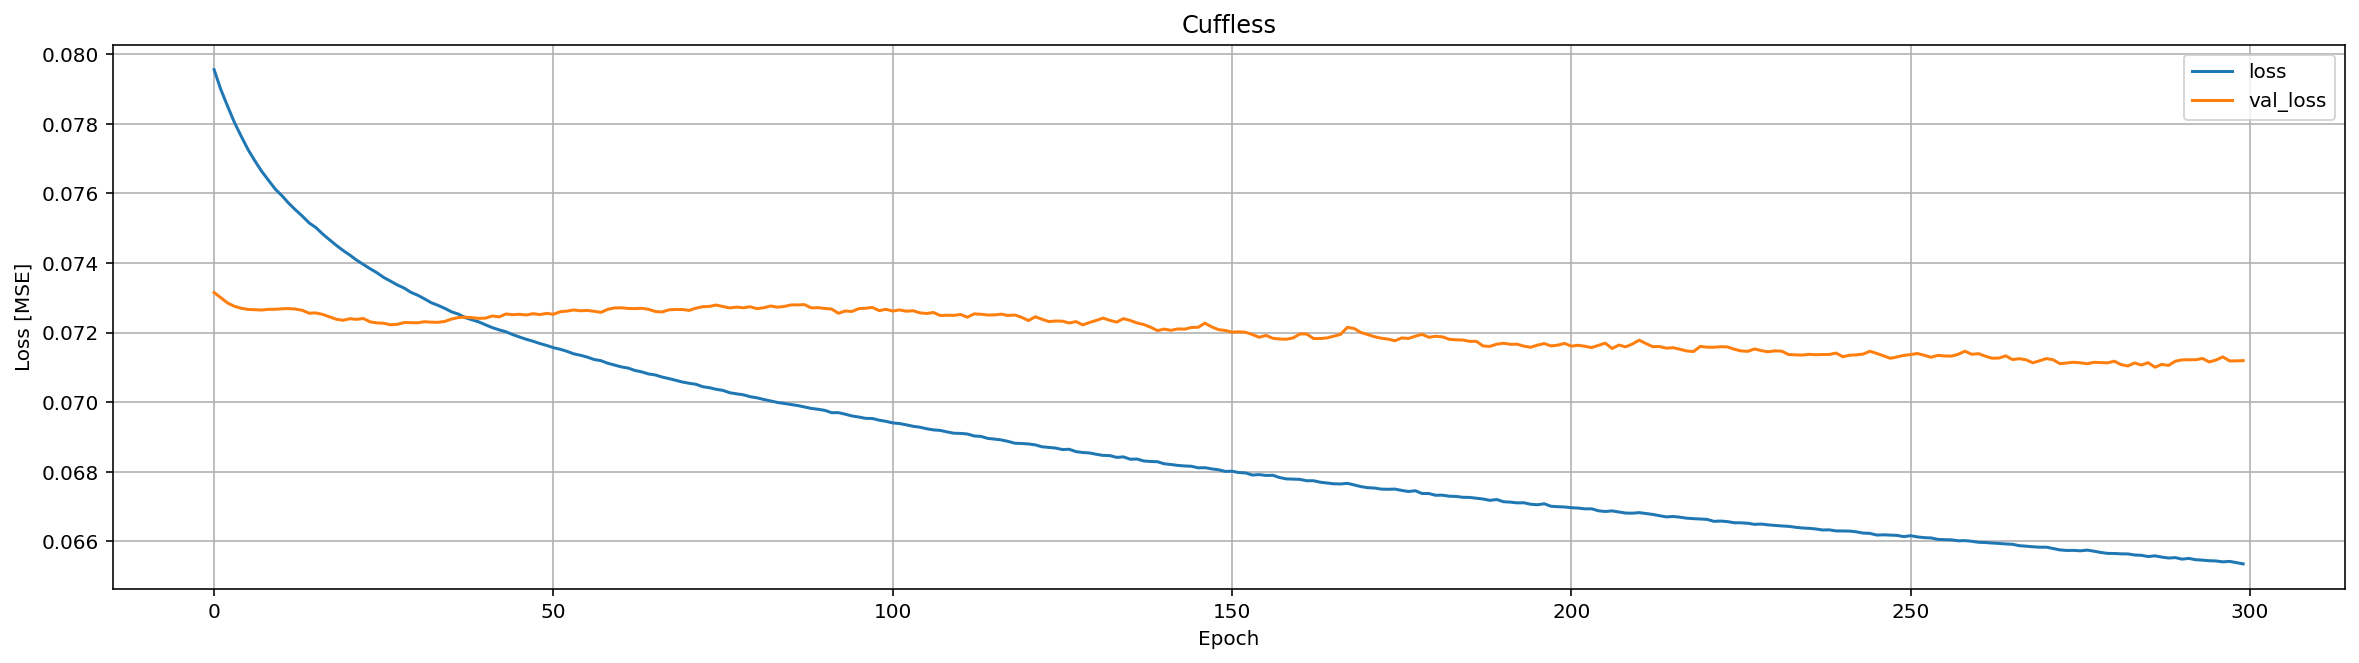

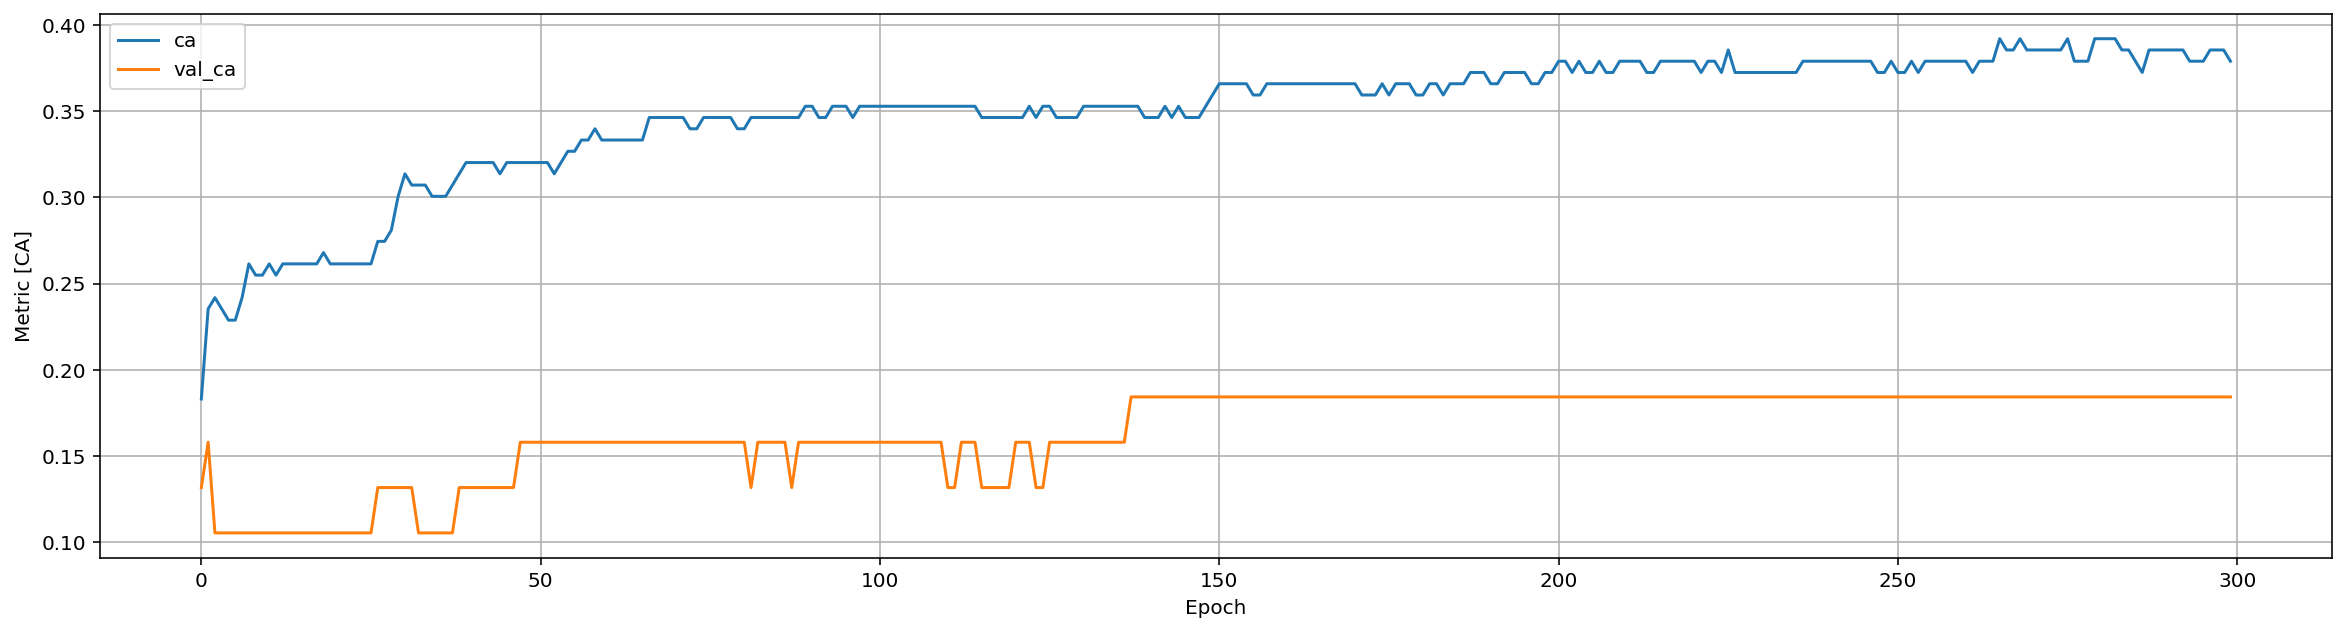

CA_val_cuffed: 0.29729729890823364


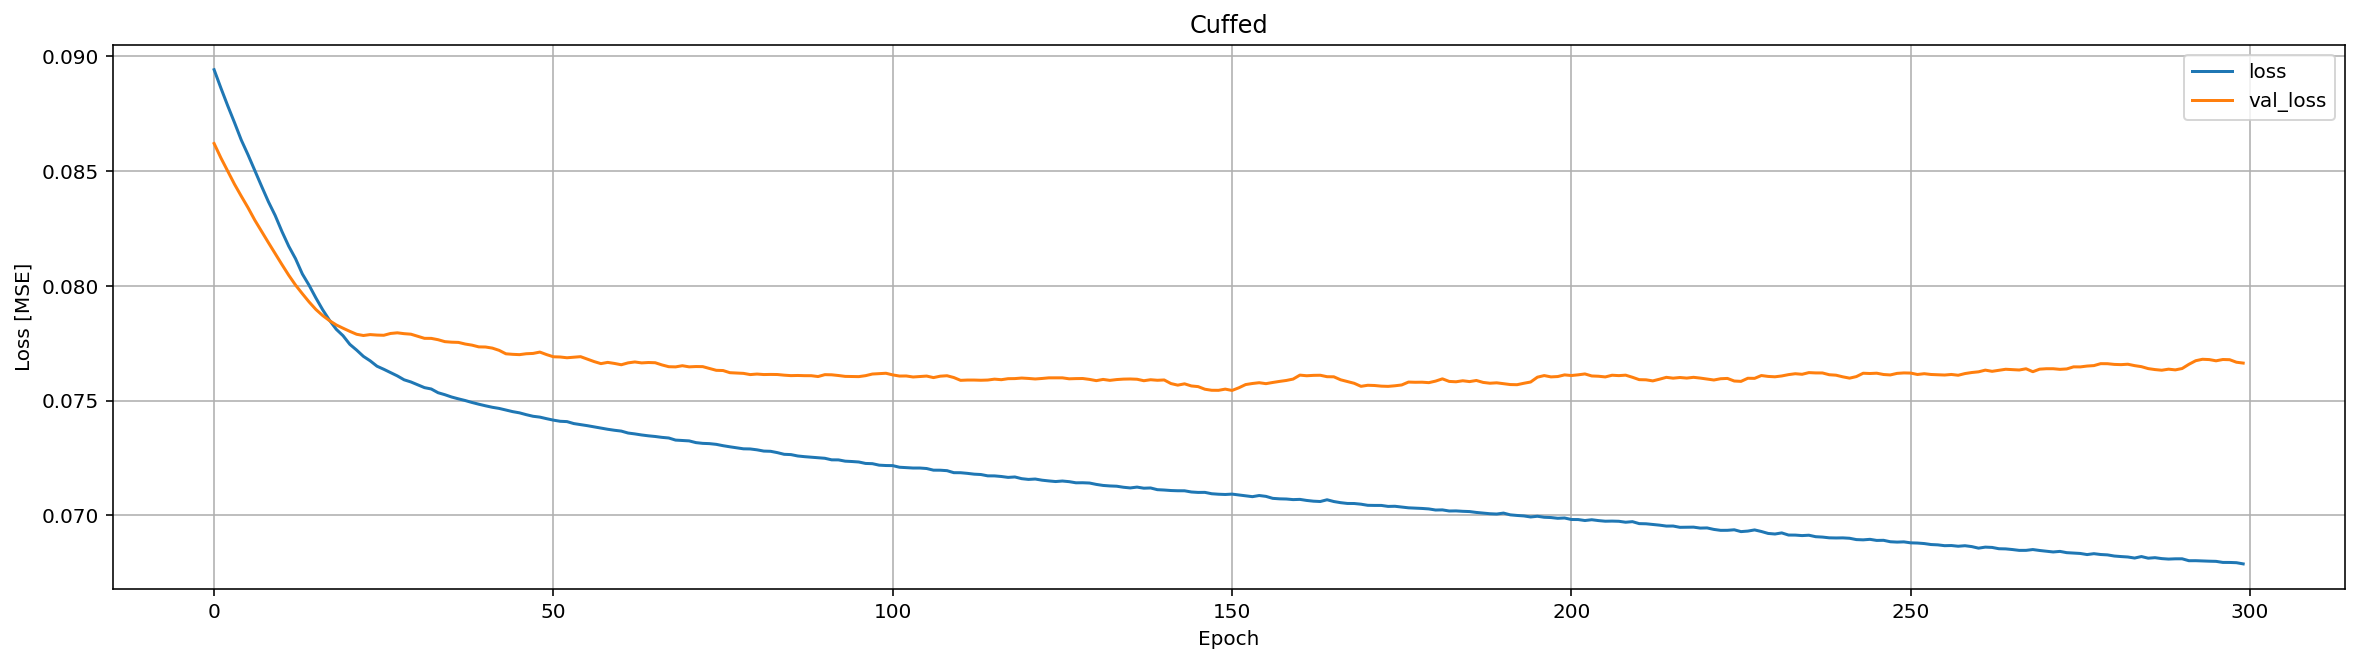

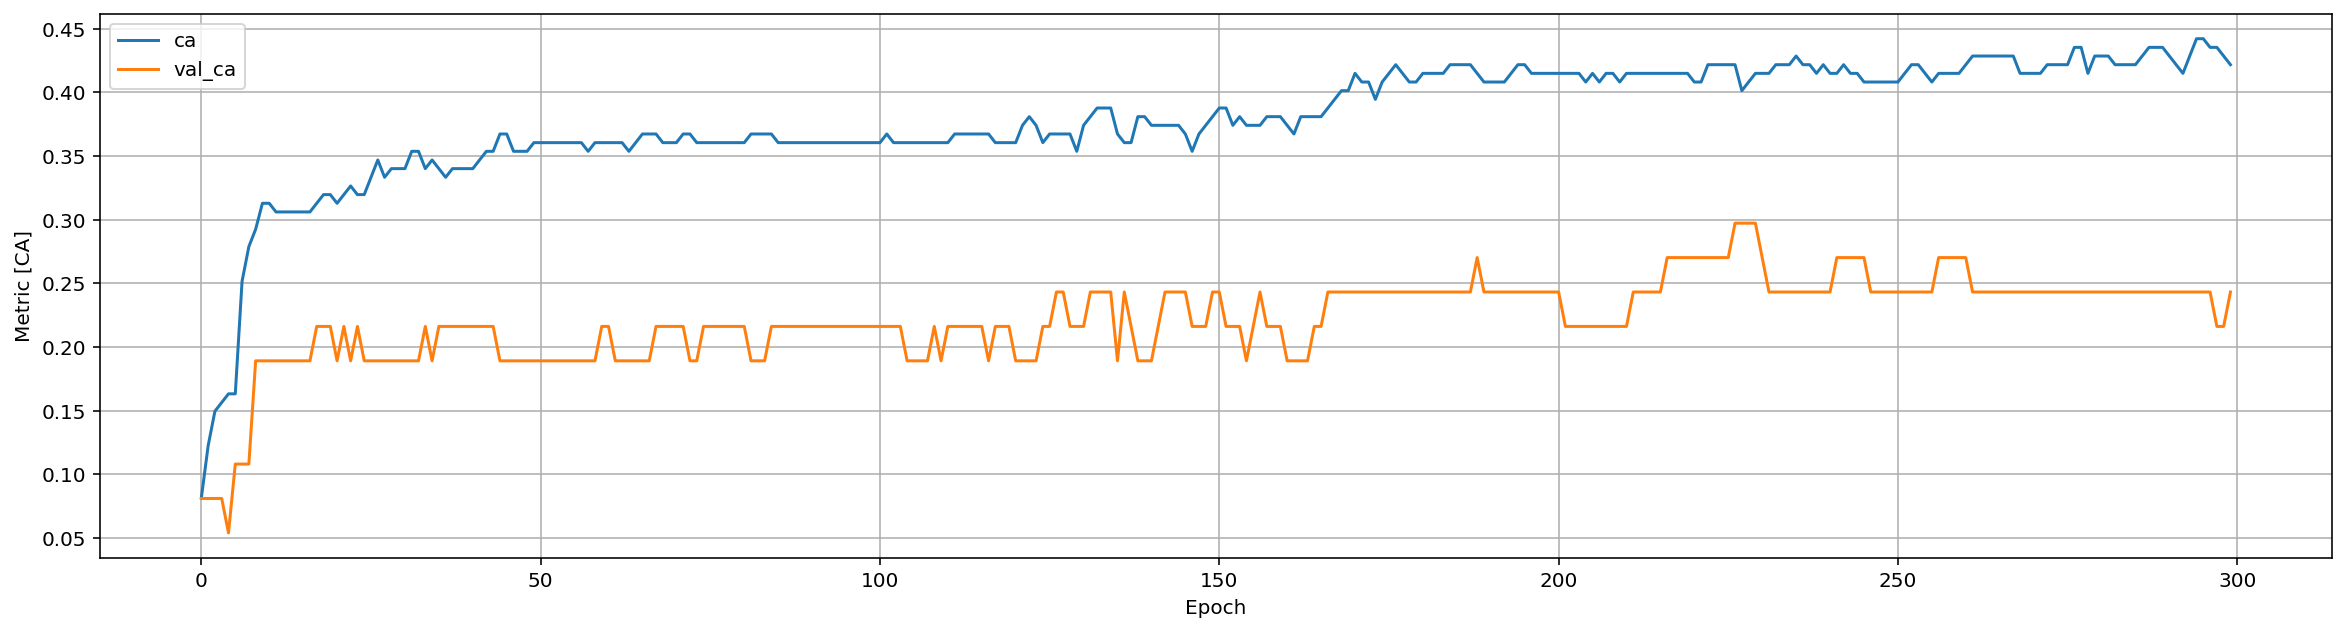

In [6]:
def plot_loss(history, name, title):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss [' + name + ']')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    
def plot_rmse(history, name, title):
    plt.plot(history.history['categorical_accuracy'], label='ca')
    plt.plot(history.history['val_categorical_accuracy'], label='val_ca')
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Metric [' + name + ']')
    plt.legend()
    plt.grid(True)

print('CA_val_cuffless: {}'.format(max(history_cuffless.history['val_categorical_accuracy'])))

plot_loss(history_cuffless, 'MSE', 'Cuffless')
plt.show()
plot_rmse(history_cuffless, 'CA', 'Cuffless')
plt.show()

print('CA_val_cuffed: {}'.format(max(history_cuffed.history['val_categorical_accuracy'])))

plot_loss(history_cuffed, 'MSE', 'Cuffed')
plt.show()
plot_rmse(history_cuffed, 'CA', 'Cuffed')
plt.show()

In [7]:
test_dataset_cuffless['OD class pred'] = np.array([np.argmax(model_cuffless(np.array([row[1][:3]])).numpy()) for row in test_dataset_cuffless.iterrows()])
test_dataset_cuffed['OD class pred'] = np.array([np.argmax(model_cuffed(np.array([row[1][:3]])).numpy()) for row in test_dataset_cuffed.iterrows()])

In [8]:
print('--- Cuffless predictions ---')
print()
print('Adapted diameter: {:.2%}'.format(sum(test_dataset_cuffless['OD class pred'] <= test_dataset_cuffless['OD class ref']) / len(test_dataset_cuffless)))
print('Exact diameter: {:.2%}'.format(sum(test_dataset_cuffless['OD class pred'] == test_dataset_cuffless['OD class ref']) / len(test_dataset_cuffless)))
print()
print('--- Cuffed predictions ---')
print()
print('Adapted diameter: {:.2%}'.format(sum(test_dataset_cuffed['OD class pred'] <= test_dataset_cuffed['OD class ref']) / len(test_dataset_cuffed)))
print('Exact diameter: {:.2%}'.format(sum(test_dataset_cuffed['OD class pred'] == test_dataset_cuffed['OD class ref']) / len(test_dataset_cuffed)))

--- Cuffless predictions ---

Adapted diameter: 57.89%
Exact diameter: 18.42%

--- Cuffed predictions ---

Adapted diameter: 62.16%
Exact diameter: 24.32%
